### Get all models from huggingface hub API

In [ ]:
from huggingface_hub import list_models, ModelCard
import pandas as pd

models = list(list_models(full=True))

In [ ]:
# save pickle files

import pickle
with open('models_info_250108.pkl', 'wb') as f:
    pickle.dump(models, f)


In [10]:
# load pickle files

import pickle
with open('models_info_250108.pkl', 'rb') as f:
    loaded_models = pickle.load(f)


In [5]:
# process metadata to csv

from huggingface_hub import list_models, ModelCard
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import ast

def parse_siblings_str(siblings_str):
    if not siblings_str or siblings_str.strip() == "[]":
        return []
    try:
        import re
        pattern = r"rfilename='([^']*)'"
        filenames = re.findall(pattern, siblings_str)
        return filenames
    except:
        return []

def process_model(model):
    """
    try:
        card = ModelCard.load(model_id)
        has_model_card = True
        model_card_content = card.text
    except Exception:
        has_model_card = False
        model_card_content = None
    """
    return {
        "modelId": model.modelId,
        "author": model.author,
        "creation_time": model.created_at,
        "last_modified": model.last_modified,
        "gated": model.gated,
        "library_name": model.library_name,
        "downloads": model.downloads,
        "likes": model.likes,
        "disabled": model.disabled,
        "private": model.private,
        "task_category": model.pipeline_tag,
        "task_domain": ", ".join(model.tags) if model.tags else "Unknown",
        "tags": model.tags,
        "mask_token": model.mask_token,
        "card_data": model.card_data,
        "widget_data": model.widget_data,
        "model_index": model.model_index,
        "config": model.config,
        "transformers_info": model.transformers_info,
        "siblings": model.siblings,
        "spaces": model.spaces,
        "safetensors": model.safetensors,
        #"has_model_card": has_model_card,  
        #"model_card_content": model_card_content,  
    }

#ModelInfo(sha=None, last_modified=None, gated=None, library_name='transformers', tags=['transformers', 'safetensors', 'phi3', 'text-generation', 'phi', 'nlp', 'math', 'code', 'chat', 'conversational', 'custom_code', 'en', 'arxiv:2412.08905', 'license:mit', 'autotrain_compatible', 'text-generation-inference', 'endpoints_compatible', 'region:us'], mask_token=None, card_data=None, widget_data=None, model_index=None, config=None, transformers_info=None, siblings=None, spaces=None, safetensors=None)

print("Processing model information in parallel with progress bar...")
processed_data = Parallel(n_jobs=-1, backend="threading")(
    delayed(process_model)(model) for model in tqdm(loaded_models, desc="Processing Models")
)

df = pd.DataFrame(processed_data)
df['siblings_list'] = df['siblings'].apply(str).apply(parse_siblings_str)
df['gated'] = df['gated'].astype('str')
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['year'] = df['creation_time'].dt.year

output_path = "huggingface_models_250108.csv"
df.to_csv(output_path)
print(f"Processed data with model card content has been saved to: {output_path}")

df.head()

Processing model information in parallel with progress bar...


NameError: name 'loaded_models' is not defined

In [12]:
processed_data[1], loaded_models[1].private

({'modelId': 'microsoft/phi-4',
  'author': 'microsoft',
  'creation_time': datetime.datetime(2024, 12, 11, 11, 47, 29, tzinfo=datetime.timezone.utc),
  'last_modified': datetime.datetime(2025, 1, 8, 20, 55, 58, tzinfo=datetime.timezone.utc),
  'gated': False,
  'library_name': 'transformers',
  'downloads': 297,
  'likes': 397,
  'disabled': None,
  'private': False,
  'task_category': 'text-generation',
  'task_domain': 'transformers, safetensors, phi3, text-generation, phi, nlp, math, code, chat, conversational, custom_code, en, arxiv:2412.08905, license:mit, autotrain_compatible, text-generation-inference, endpoints_compatible, region:us',
  'tags': ['transformers',
   'safetensors',
   'phi3',
   'text-generation',
   'phi',
   'nlp',
   'math',
   'code',
   'chat',
   'conversational',
   'custom_code',
   'en',
   'arxiv:2412.08905',
   'license:mit',
   'autotrain_compatible',
   'text-generation-inference',
   'endpoints_compatible',
   'region:us'],
  'mask_token': None,
  '

### Get statistics

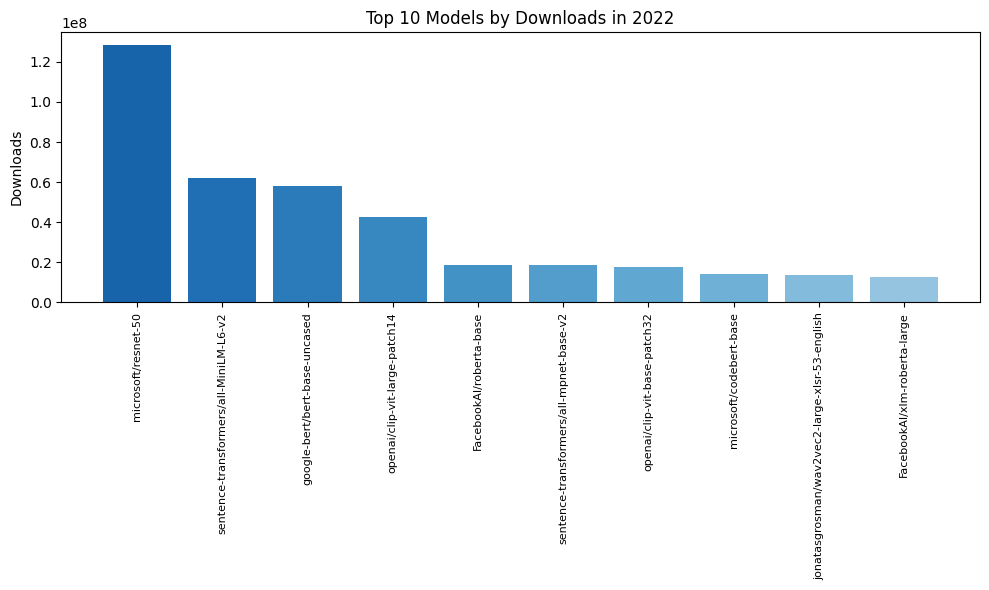

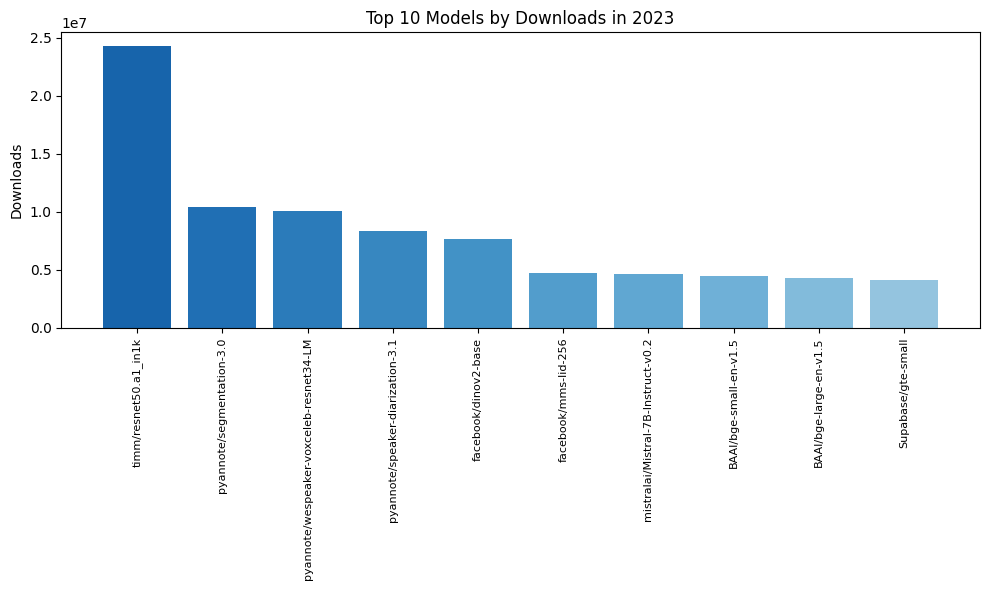

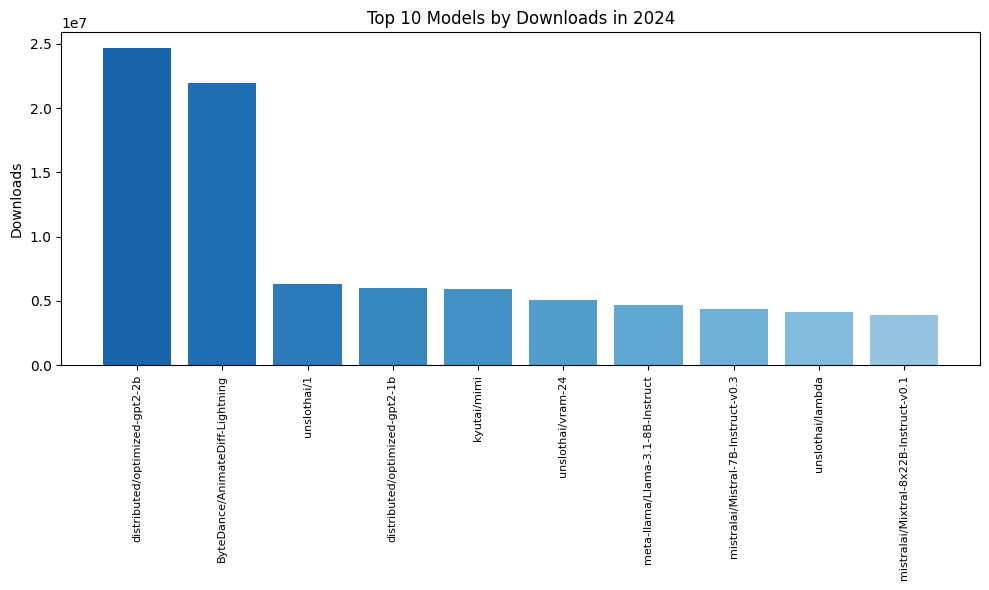

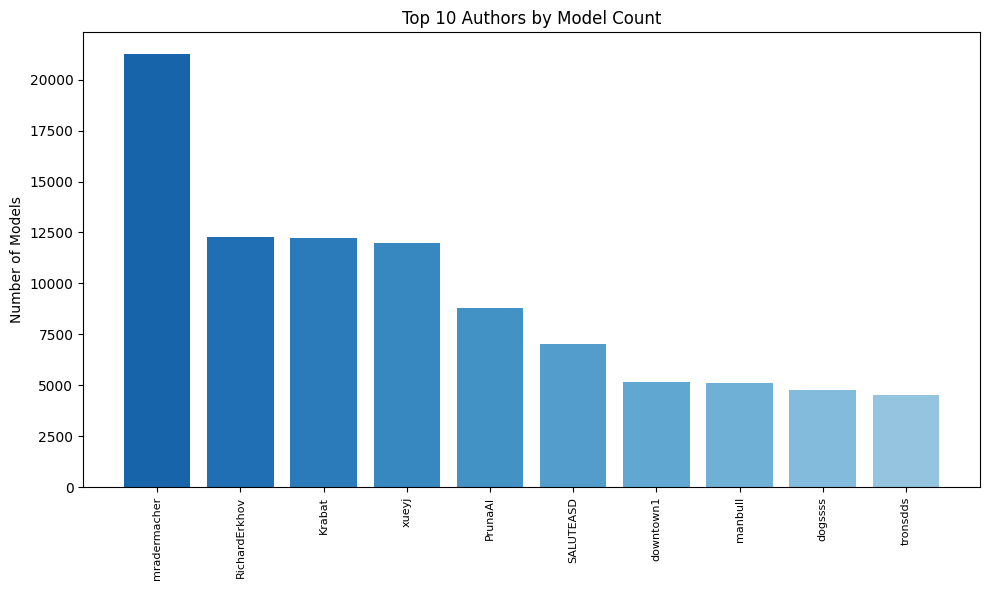

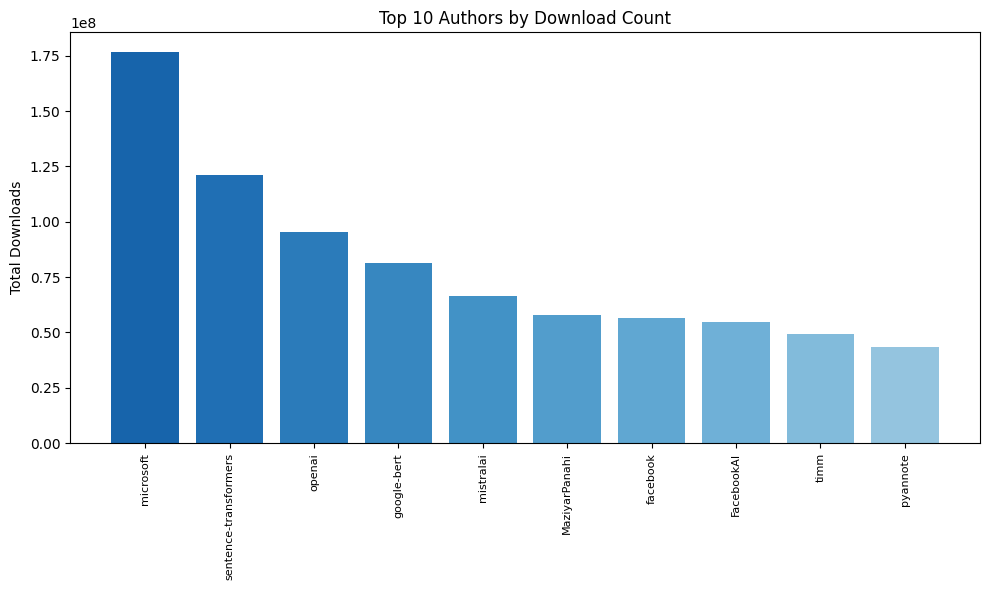

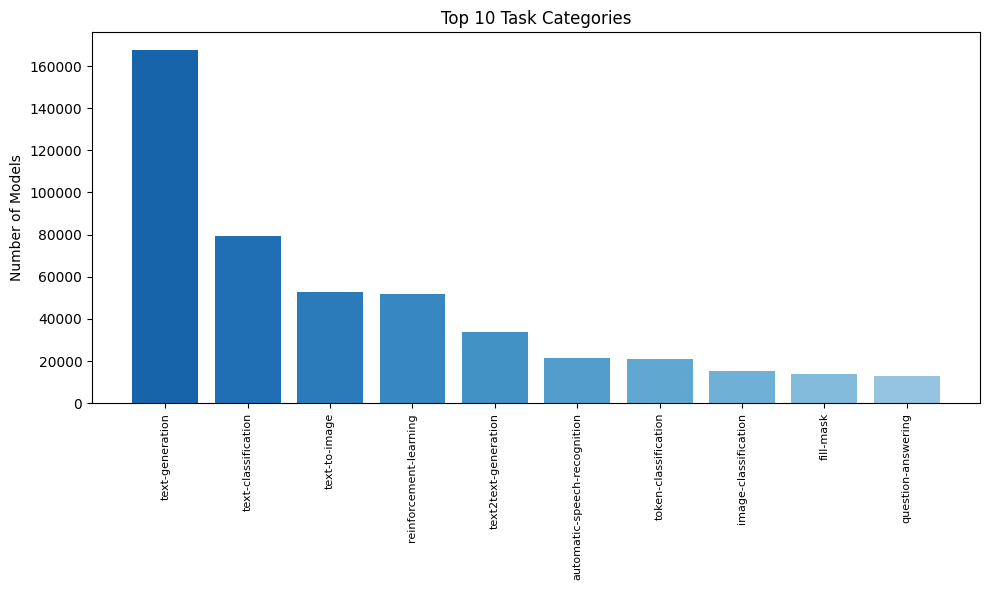

/var/folders/sw/gx57sf_s48530_wzcytrf5jc0000gn/T/ipykernel_7570/1365144241.py:69: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


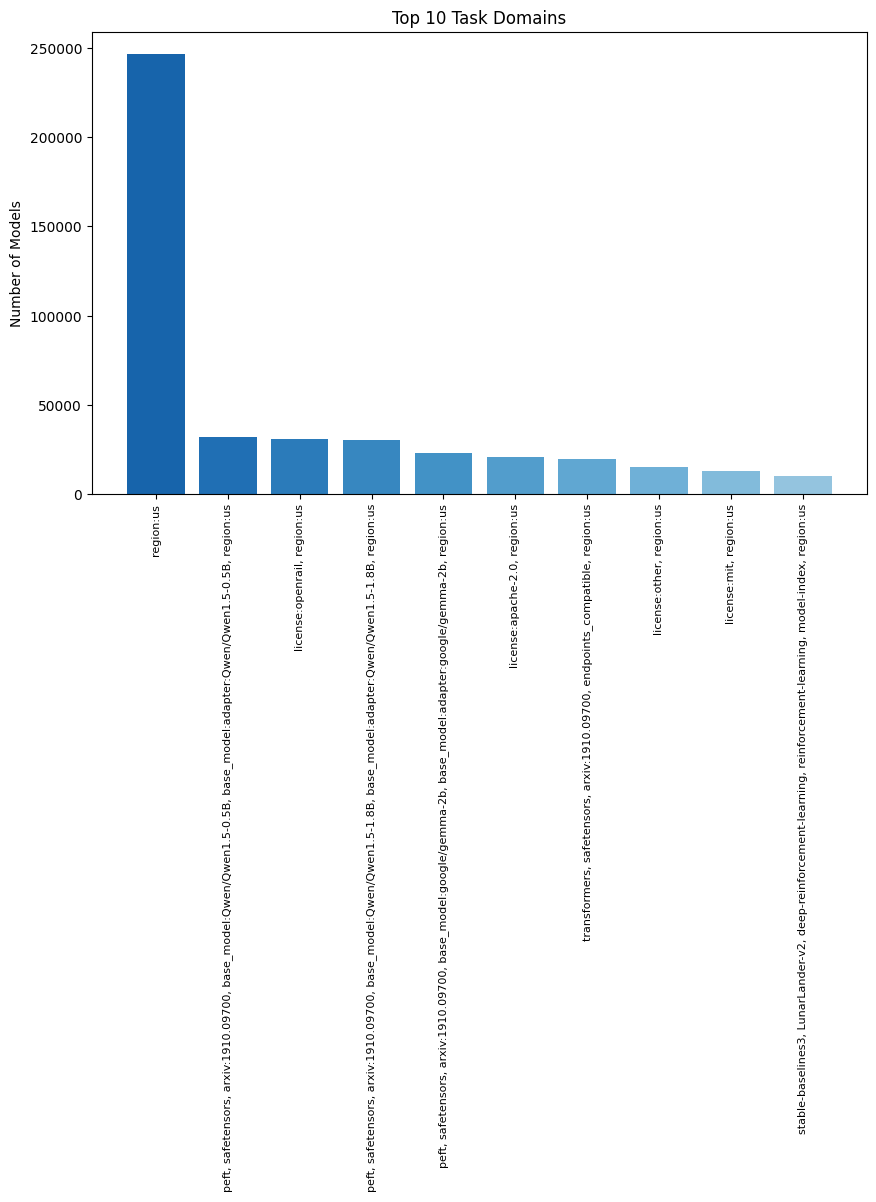

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

TOP_K = 10

csv_path = "huggingface_models_250108.csv"
df = pd.read_csv(csv_path)
#df['creation_time'] = pd.to_datetime(df['creation_time'])
#df['year'] = df['creation_time'].dt.year
creation_time_range = (df['creation_time'].min(), df['creation_time'].max())

for year in range(2018, 2025):
    df_year = df[df['year'] == year].sort_values(by='downloads', ascending=False).head(TOP_K)
    if not df_year.empty:
        plt.figure(figsize=(10, 6))
        plt.bar(df_year['modelId'], df_year['downloads'], color=plt.cm.Blues(np.linspace(0.8, 0.4, len(df_year))))
        plt.xticks(rotation=90, fontsize=8)
        plt.title(f"Top {TOP_K} Models by Downloads in {year}")
        plt.ylabel("Downloads")
        plt.tight_layout()
        plt.savefig(f"top_{TOP_K}_models_by_downloads_{year}.png")
        plt.show()
        plt.close()

author_counts = df['author'].value_counts().head(TOP_K)

plt.figure(figsize=(10, 6))
plt.bar(author_counts.index, author_counts.values, color=plt.cm.Blues(np.linspace(0.8, 0.4, len(author_counts))))
plt.xticks(rotation=90, fontsize=8)
plt.title(f"Top {TOP_K} Authors by Model Count")
plt.ylabel("Number of Models")
plt.tight_layout()
plt.savefig(f"top_{TOP_K}_authors_by_model_count.png")
plt.show()
plt.close()

author_downloads = df.groupby('author')['downloads'].sum().sort_values(ascending=False).head(TOP_K)

plt.figure(figsize=(10, 6))
plt.bar(author_downloads.index, author_downloads.values, color=plt.cm.Blues(np.linspace(0.8, 0.4, len(author_downloads))))
plt.xticks(rotation=90, fontsize=8)
plt.title(f"Top {TOP_K} Authors by Download Count")
plt.ylabel("Total Downloads")
plt.tight_layout()
plt.savefig(f"top_{TOP_K}_authors_by_download_count.png")
plt.show()
plt.close()

task_category_counts = df['task_category'].value_counts().head(TOP_K)

plt.figure(figsize=(10, 6))
plt.bar(task_category_counts.index, task_category_counts.values, color=plt.cm.Blues(np.linspace(0.8, 0.4, len(task_category_counts))))
plt.xticks(rotation=90, fontsize=8)
plt.title(f"Top {TOP_K} Task Categories")
plt.ylabel("Number of Models")
plt.tight_layout()
plt.savefig(f"top_{TOP_K}_task_categories.png")
plt.show()
plt.close()

task_domain_counts = df['task_domain'].value_counts().head(TOP_K)

plt.figure(figsize=(10, 6))
plt.bar(task_domain_counts.index, task_domain_counts.values, color=plt.cm.Blues(np.linspace(0.8, 0.4, len(task_domain_counts))))
plt.xticks(rotation=90, fontsize=8)
plt.title(f"Top {TOP_K} Task Domains")
plt.ylabel("Number of Models")
plt.tight_layout()
plt.savefig(f"top_{TOP_K}_task_domains.png")
plt.show()
plt.close()


In [7]:
# all file types
# Ensure necessary imports
import pandas as pd

# Assuming `df` is your main DataFrame with a column 'siblings_list'
# Step 1: Explode the `siblings_list` column to get all filenames in one column
exploded_files = df['siblings_list'].explode()

# Step 2: Extract file extensions
def extract_file_extension(filename):
    """
    Extracts the file extension from a filename.
    If no extension exists, returns 'no_extension'.
    """
    if isinstance(filename, str) and '.' in filename:
        return '.' + filename.split('.')[-1].lower()  # Extract the extension and convert to lowercase
    return 'no_extension'  # Handle cases where there's no extension

file_extensions = exploded_files.apply(extract_file_extension)

# Step 3: Count occurrences of each file extension
file_extension_counts = file_extensions.value_counts()

# Step 4: Display the results
print("File type counts across all repositories:")
file_extension_counts.head(20)

File type counts across all repositories:


.json']             439674
.bin']              195595
.gitattributes']    148667
.safetensors']      103972
.txt']               93021
.md']                90558
.gguf']              40194
.zip']               34474
.jpg']               13891
.pth']                9628
.png']                8987
.pt']                 8392
.py']                 7454
.dat']                6904
.yml']                6474
.pkl']                5579
.ckpt']               5063
.mp4']                4076
.h5']                 4015
.index']              2684
Name: siblings_list, dtype: int64

In [8]:
def is_default_file(fname):
    """
    Determines whether a file is considered a default or non-model file.
    
    Default files include:
    1. Files starting with "license" or "." (hidden files, LICENSE files, etc.)
    2. Files ending with specific extensions such as .md, .png, .jpg, .txt, .py
    3. Additional formats can be added as needed.
    """
    fname_lower = fname.lower()
    # Files starting with "license" or hidden files
    if fname_lower.startswith("license") or fname_lower.startswith("."):
        return True
    # Common non-model file extensions
    non_model_extensions = [
        ".md",         # Markdown files (documentation)
        ".png",        # Image files
        ".jpg",        # Image files
        ".jpeg",       # Image files
        ".txt",        # Text files (e.g., logs, readmes)
        ".py",         # Python scripts
        ".json",       # JSON files (e.g., configurations, metadata)
        ".csv",        # CSV files (data files)
        ".yaml",       # YAML files (e.g., configurations)
        ".yml",        # YAML files (alternative extension)
        ".mp4",        # Video files
        ".wav",        # Audio files
        ".js",         # JavaScript files (unlikely to store models)
        ".apk",        # Android application files (not model files directly)
        ".meta",       # Metadata files (e.g., TensorFlow graph metadata)
        ".mp3",        # Audio files
        ".ipynb",       # Jupyter notebook files (code or documentation)
        ".sh",
        ".DS_Store"
    ]  # Note: ".zip" and ".tar" are excluded as they may contain model files.
    if any(fname_lower.endswith(ext) for ext in non_model_extensions):
        return True
    return False

def has_extra_siblings(filenames_list):
    return any(not is_default_file(fname) for fname in filenames_list)

def is_model_file(fname):
    """
    Identifies if a file is an actual model file.
    """
    fname_lower = fname.lower()
    model_extensions = [
        ".bin",         # PyTorch
        ".safetensors", # SafeTensors
        ".h5",          # TensorFlow
        ".onnx",        # ONNX
        ".msgpack",     # Flax/JAX
        ".pth",         # PyTorch checkpoint
        ".pt",          # PyTorch
        ".pkl",         # Pickle
        ".pb",          # TensorFlow protobuf
        ".gguf",        # llama.cpp-specific format
        ".ckpt",        # General checkpoint
        ".npz",         # Numpy archive
        ".npy",         # Numpy binary file (can store arrays or weights)
        ".weight",      # General file naming for model weights, ambiguous but used in custom frameworks
        ".eqx",         # Equinox-specific model files for JAX/Flax libraries
        ".cleanrl_model" # Checkpoint format specific to CleanRL reinforcement learning framework
    ]
    if any(fname_lower.endswith(ext) for ext in model_extensions):
        return True
    return False

def has_model_files(filenames_list):
    """
    Determines if a repository contains at least one model file.
    """
    return any(is_model_file(fname) for fname in filenames_list)

#df_non_empty_siblings = df[df['siblings_list'].apply(has_extra_siblings)]

In [9]:
import ast

df['siblings_list'] = df['siblings_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_non_empty_siblings = df[df['siblings_list'].apply(has_extra_siblings)]
print(len(df_non_empty_siblings))

df_with_model_files = df[df['siblings_list'].apply(has_model_files)]
print(len(df_with_model_files))

1034821
976853


In [10]:
# Step 1: Find the difference between the two DataFrames
diff_df = df_non_empty_siblings[~df_non_empty_siblings.index.isin(df_with_model_files.index)]

# Step 2: Check the count of repositories in `diff_df`
len_diff = len(diff_df)
print(f"Number of repositories with extra siblings but no model files: {len_diff}")

# Step 3: Explode the `siblings_list` column and count file extensions
# Explode the `siblings_list` column to create one row per file
exploded_files = diff_df['siblings_list'].explode()

# Step 4: Extract file extensions from the exploded files
file_extensions = exploded_files.apply(
    lambda x: '.' + x.split('.')[-1] if isinstance(x, str) and '.' in x else 'no_extension'
)

# Step 5: Count occurrences of each file extension
file_extension_counts = file_extensions.value_counts()

# Step 6: Display the most common file extensions
print("Most common file extensions in repositories without model files:")
file_extension_counts.head(45)


Number of repositories with extra siblings but no model files: 57978
Most common file extensions in repositories without model files:


.zip              111759
.png               97863
no_extension       85370
.jpg               60886
.gitattributes     57732
.py                53945
.md                44280
.json              36972
.tar               36496
.txt               31399
.0                 21796
.js                17944
.yaml              14386
.jsonl             13539
.gz                12101
.flac              11879
.whl               11460
.jpeg              10941
.glb               10729
.pyc               10410
.mp3                9240
.mp4                8420
.apk                8227
.php                8121
.wav                7997
.h                  7959
.new                7808
.pdf                7504
.ts                 6453
.jar                6318
.c                  6162
.html               6151
.1                  5389
.cpp                5154
.lean               4828
.gif                4779
.pickle             4577
.obj                4178
.5                  3546
.mtl                3414


Number of repositories with downloads > 0: 595915


/var/folders/sw/gx57sf_s48530_wzcytrf5jc0000gn/T/ipykernel_33365/2659292905.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_downloads['base_model_name'] = df_filtered_downloads['modelId'].apply(lambda x: x.split('/')[-1])


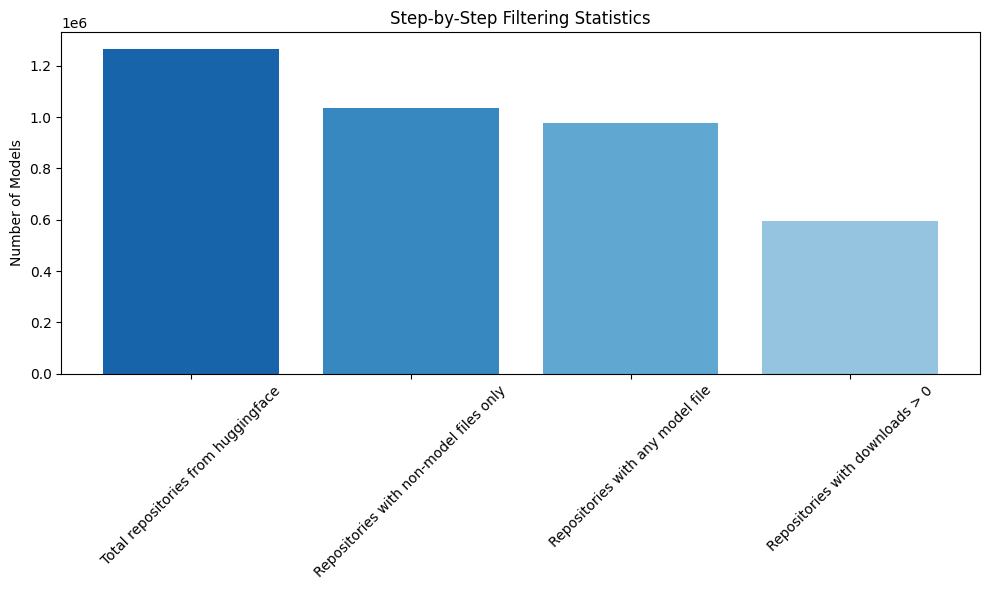

Updated step-by-step filtering chart has been saved.


In [11]:
# 7. Rules-based filtering: At least 1 download and deduplication
# Rule 1: Filter out disabled models (this attribute is all None)
#df_enabled = df[df['disabled'] == False]
# Rule 2: Filter out private models (all public from API retrieving)
#df_public = df_enabled[df_enabled['private'] == False]

#df_non_empty_siblings = df[df['siblings_list'].apply(has_extra_siblings)]
#df_with_model_files = df_non_empty_siblings[df_non_empty_siblings['siblings_list'].apply(has_model_files)]


# Step 3: Rule 3 - Filter out models with 0 downloads
df_filtered_downloads = df_with_model_files[df_with_model_files['downloads'] > 0]
print(f"Number of repositories with downloads > 0: {len(df_filtered_downloads)}")

# Step 4: Rule 4 - Deduplication: Keep only the highest download per model base name
df_filtered_downloads['base_model_name'] = df_filtered_downloads['modelId'].apply(lambda x: x.split('/')[-1])
#df_unique_model_names = df_filtered_downloads.loc[
#    df_filtered_downloads.groupby('base_model_name')['downloads'].idxmax()
#]
#print(f"Number of unique repositories (based on highest downloads per model): {len(df_unique_model_names)}")

# Step 5: Calculate counts at each step
total_models = len(df)
models_with_siblings = len(df_non_empty_siblings)
models_with_model_files = len(df_with_model_files)
models_with_downloads = len(df_filtered_downloads)
#models_unique_by_name_only = len(df_unique_model_names)

# Step 6: Plot the step-by-step filtering statistics
step_conditions = [
    "Total repositories from huggingface",
    "Repositories with non-model files only",
    "Repositories with any model file",
    "Repositories with downloads > 0",
    #"Unique repositories by name",
]
step_values = [
    total_models,
    models_with_siblings,
    models_with_model_files,
    models_with_downloads,
    #models_unique_by_name_only,
]

plt.figure(figsize=(10, 6))
plt.bar(step_conditions, step_values, color=plt.cm.Blues(np.linspace(0.8, 0.4, len(step_conditions))))
plt.xticks(rotation=45, fontsize=10)
plt.title("Step-by-Step Filtering Statistics")
plt.ylabel("Number of Models")
plt.tight_layout()
plt.savefig("step_by_step_filtering_statistics_updated_rules.png")
plt.show()

print("Updated step-by-step filtering chart has been saved.")

In [3]:
"""from huggingface_hub import HfApi, ModelCard
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import re

# Initialize the Hugging Face API
api = HfApi()

def retrieve_model_info(model_id):
    try:
        # Use ModelCard to retrieve structured information
        model_card = ModelCard.load(model_id)
        new_info = {
            "new_base_model": model_card.data.get("base_model"),
            "new_card_data": model_card.data,
            "new_readme": model_card.text,
        }
        return new_info
    except Exception as e:
        print(f"Error retrieving model info for {model_id}: {e}")
        return {
            "new_base_model": None,
            "new_card_data": {},
            "new_readme": "",
        }

# Create a new copy of df_filtered_downloads
updated_df = df.copy()

# Add new fields to the DataFrame
new_columns = ["new_base_model", "new_card_data", "new_readme"]
for col in new_columns:
    if col not in updated_df.columns:
        updated_df[col] = None

# Use Parallel processing to speed up retrieval
def process_row(idx, row):
    model_id = row['modelId']
    return idx, retrieve_model_info(model_id)

results = Parallel(n_jobs=-1, backend="threading")(delayed(process_row)(idx, row) for idx, row in tqdm(updated_df.iterrows(), total=len(updated_df)))

# Update DataFrame with results
for idx, card_data in results:
    for key, value in card_data.items():
        updated_df.at[idx, key] = value

# Save the updated DataFrame with model cards to CSV
output_csv_path = "updated_models_with_carddata.csv"
updated_df.to_csv(output_csv_path, index=False)
print(f"Updated DataFrame with model cards saved to {output_csv_path}")"""

In [12]:
from huggingface_hub import HfApi, ModelCard
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import os

# Initialize the Hugging Face API
api = HfApi()

# Output CSV path
output_csv_path = "updated_models_with_carddata.csv"

# Check if DataFrame exists or load it
if 'df' not in locals() and 'df' not in globals():
    if os.path.exists(output_csv_path):
        df = pd.read_csv(output_csv_path)
    else:
        raise FileNotFoundError("No DataFrame found in memory or saved file.")

# Ensure the 'retrieved_cardinfo' column exists
if "retrieved_cardinfo" not in df.columns:
    df["retrieved_cardinfo"] = False

# Retrieve model info function
def retrieve_model_info(model_id):
    try:
        model_card = ModelCard.load(model_id)
        return {
            "retrieved_cardinfo": True,
            "new_base_model": model_card.data.get("base_model"),
            "new_card_data": model_card.data,
            "new_readme": model_card.text,
        }
    except Exception as e:
        print(f"Error retrieving model info for {model_id}: {e}")
        return {
            "retrieved_cardinfo": True,
            "new_base_model": None,
            "new_card_data": {},
            "new_readme": "",
        }

# Save DataFrame periodically
def save_progress(df, path):
    temp_path = path + ".tmp"
    df.to_csv(temp_path, index=False)
    os.replace(temp_path, path)  # Atomically replace the old file
    print(f"Progress saved to {path}")

# Main processing logic
def process_models(df, chunk_size=100):
    # Process only rows that haven't been retrieved yet
    rows_to_process = df[df["retrieved_cardinfo"] == False]

    for start_idx in range(0, len(rows_to_process), chunk_size):
        end_idx = min(start_idx + chunk_size, len(rows_to_process))
        chunk = rows_to_process.iloc[start_idx:end_idx]

        results = Parallel(n_jobs=-1, backend="threading")(delayed(retrieve_model_info)(row["modelId"]) for _, row in tqdm(chunk.iterrows(), total=len(chunk), desc=f"Processing chunk {start_idx // chunk_size + 1}"))

        # Update the DataFrame with results
        for idx, result in zip(chunk.index, results):
            for key, value in result.items():
                #df.at[idx, key] = value
                df.loc[idx, key] = value


        # Save progress
        save_progress(df, output_csv_path)

# Execution
if __name__ == "__main__":
    # Process models in chunks
    process_models(df)


Progress saved to updated_models_with_carddata.csv


Processing chunk 11:  40%|████      | 40/100 [00:03<00:07,  8.34it/s]

Error retrieving model info for camenduru/FLUX.1-dev: 404 Client Error. (Request ID: Root=1-6785f904-7c18ea3037bafd8b40a6ad36;139c6bd0-3a2f-4c7f-882f-40ba77cd58f3)

Entry Not Found for url: https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/README.md.


Processing chunk 11: 100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


OSError: [Errno 28] No space left on device

In [13]:
df

KeyError: 0

KeyError: 0

In [31]:
import pandas as pd

# 假设 df['tags'] 每一行是一个字符串形式的列表
# 首先将每一行转换为 Python 列表
df['tags_list'] = df['tags'].apply(eval)  # 如果已经是列表类型，跳过这一步

# 检查哪些行包含 "arxiv:"，并计算比例
arxiv_count = df['tags_list'].apply(lambda x: any('arxiv:' in tag for tag in x))
proportion_with_arxiv = arxiv_count.sum() / len(df)

print(f"Proportion of rows with arXiv links: {proportion_with_arxiv:.2%}")


  6%|▌         | 36839/595915 [1:11:09<17:59:51,  8.63it/s]


Proportion of rows with arXiv links: 20.12%


In [ ]:
import pandas as pd

# 假设 df['tags'] 每一行是一个字符串形式的列表
# 首先将每一行转换为 Python 列表
df_filtered_downloads['tags_list'] = df_filtered_downloads['tags'].apply(eval)  # 如果已经是列表类型，跳过这一步

# 检查哪些行包含 "arxiv:"，并计算比例
arxiv_count = df_filtered_downloads['tags_list'].apply(lambda x: any('arxiv:' in tag for tag in x))
proportion_with_arxiv = arxiv_count.sum() / len(df_filtered_downloads)

print(f"Proportion of rows with arXiv links: {proportion_with_arxiv:.2%}")


In [33]:
df_filtered_downloads['tags']

0          ['safetensors', 'deepseek_v3', 'custom_code', ...
1          ['transformers', 'safetensors', 'phi3', 'text-...
2          ['transformers', 'safetensors', 'qwen2', 'text...
3          ['onnx', 'text-to-speech', 'en', 'arxiv:2306.0...
4          ['diffusers', 'safetensors', 'text-to-image', ...
                                 ...                        
1263476    ['transformers', 'tensorboard', 'safetensors',...
1263539    ['peft', 'tensorboard', 'safetensors', 'llama-...
1263673    ['safetensors', 'florence2', 'custom_code', 'l...
1264019    ['transformers', 'tensorboard', 'safetensors',...
1264042    ['transformers', 'safetensors', 'layoutlmv3', ...
Name: tags, Length: 595915, dtype: object

In [ ]:
from huggingface_hub import HfApi, ModelCard

api = HfApi()
try:
    model_card = ModelCard.load('dora2023/test')
    print("Model Card Retrieved Successfully")
except Exception as e:
    model_card = f"Error retrieving model card: {e}"
print(model_card)


In [14]:
from huggingface_hub import HfApi

# Initialize the Hugging Face API
api = HfApi()

# Example model ID
example_model_id = "hexgrad/Kokoro-82M"  # Replace with the model of interest

# Fetch metadata for the model
metadata = api.model_info(example_model_id)

# Display relevant metadata, including configuration and parent information
print("Model Metadata:")
print(metadata)

print(metadata.private)
print(metadata.disabled)
print(metadata.gated)
print(metadata.tags)
print(metadata.card_data)
print(metadata.card_data.base_model)
print(metadata.card_data.pipeline_tag)
print(print(metadata.card_data))

Model Metadata:
ModelInfo(id='hexgrad/Kokoro-82M', author='hexgrad', sha='c97b7bbc3e60f447383c79b2f94fee861ff156ac', created_at=datetime.datetime(2024, 12, 26, 0, 20, 8, tzinfo=datetime.timezone.utc), last_modified=datetime.datetime(2025, 1, 6, 20, 52, 51, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=11354, likes=877, library_name=None, tags=['onnx', 'text-to-speech', 'en', 'arxiv:2306.07691', 'arxiv:2203.02395', 'base_model:yl4579/StyleTTS2-LJSpeech', 'base_model:quantized:yl4579/StyleTTS2-LJSpeech', 'license:apache-2.0', 'region:us'], pipeline_tag='text-to-speech', mask_token=None, card_data={'language': ['en'], 'license': 'apache-2.0', 'library_name': None, 'tags': None, 'base_model': ['yl4579/StyleTTS2-LJSpeech'], 'datasets': None, 'metrics': None, 'eval_results': None, 'model_name': None, 'pipeline_tag': 'text-to-speech'}, widget_data=None, model_index=None, config={}, transformers_info=None, siblings=[RepoSibling(rfilename='.gitattributes',

In [112]:
df.columns
empty_columns = df.columns[df.isnull().all()].tolist()
empty_columns

['disabled',
 'mask_token',
 'card_data',
 'widget_data',
 'model_index',
 'config',
 'transformers_info',
 'spaces',
 'safetensors']

In [ ]:
ModelInfo(id='hexgrad/Kokoro-82M', 
          author='hexgrad', 
          sha='c97b7bbc3e60f447383c79b2f94fee861ff156ac', 
          created_at=datetime.datetime(2024, 12, 26, 0, 20, 8, tzinfo=datetime.timezone.utc), 
          last_modified=datetime.datetime(2025, 1, 6, 20, 52, 51, tzinfo=datetime.timezone.utc), 
          private=False, 
          gated=False, 
          disabled=False, 
          downloads=8097, 
          likes=710, 
          library_name=None, 
          tags=['onnx', 'text-to-speech', 'en', 'arxiv:2306.07691', 'arxiv:2203.02395', 'base_model:yl4579/StyleTTS2-LJSpeech', 'base_model:quantized:yl4579/StyleTTS2-LJSpeech', 'license:apache-2.0', 'region:us'], 
          pipeline_tag='text-to-speech', 
          mask_token=None, 
          card_data={'language': ['en'], 'license': 'apache-2.0', 'library_name': None, 'tags': None, 'base_model': ['yl4579/StyleTTS2-LJSpeech'], 'datasets': None, 'metrics': None, 'eval_results': None, 'model_name': None, 'pipeline_tag': 'text-to-speech'}, 
          widget_data=None, 
          model_index=None, 
          config={}, 
          transformers_info=None, 
          siblings=[RepoSibling(rfilename='.gitattributes', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='README.md', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='config.json', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='demo/HEARME.txt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='demo/HEARME.wav', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='demo/TTS-Spaces-Arena-25-Dec-2024.png', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='demo/af_sky.txt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='demo/af_sky.wav', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='demo/restoring-sky.md', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='fp16/halve.py', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='fp16/kokoro-v0_19-half.pth', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='istftnet.py', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='kokoro-v0_19.onnx', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='kokoro-v0_19.pth', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='kokoro.py', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='models.py', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='plbert.py', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/af.pt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/af_bella.pt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/af_nicole.pt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/af_sarah.pt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/af_sky.pt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/am_adam.pt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/am_michael.pt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/bf_emma.pt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/bf_isabella.pt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/bm_george.pt', size=None, blob_id=None, lfs=None), RepoSibling(rfilename='voices/bm_lewis.pt', size=None, blob_id=None, lfs=None)], 
          spaces=['hexgrad/Kokoro-TTS', 'Pendrokar/TTS-Spaces-Arena', 'Remsky/Kokoro-TTS-Zero', 'Wismut/Kokoro_TTS_Compare', 'RORONovaLuffy/hexgrad-Kokoro-82M', 'tgu6/hexgrad-Kokoro-82M', 'Nymbo/Kokoro-TTS-Zero', 'portalniy-dev/tts', 'Masterdqqq/vepp-tts', 'brainzcode/hexgrad-Kokoro-82M', 'joseph6377/hexgrad-Kokoro-82M9', 'Daemontatox/Fast_TTS', 'piopio88/hexgrad-Kokoro-82M', 'traghav/hexgrad-Kokoro-82M', 'joaocarloscruz/hexgrad-Kokoro-82M'], 
          safetensors=None)


In [44]:
# time duration
df['creation_time'].min(), df['creation_time'].max(), df['last_modified'].min(), df['last_modified'].max()

('2022-03-02 23:29:04+00:00', '2025-01-09 02:16:27+00:00')

In [ ]:
# get model cards


In [22]:
# empty columns
nan_columns = df.columns[df.isna().all()].tolist()
print(f"Columns with all NaN values: {nan_columns}")

Columns with all NaN values: ['disabled', 'mask_token', 'card_data', 'widget_data', 'model_index', 'config', 'transformers_info', 'spaces', 'safetensors']


In [6]:
from huggingface_hub import list_models, ModelCard
import pandas as pd

models = list(list_models(limit=100))